## Задача 5.1

[Дана выборка](data/regression.zip)

Выборка состоит из трех обзектов: X_train, Y_train, X_test

Y_train - изображение (пиксель кодируется черно-белой компонентой изображения), X_train - признаки, соответствующие этому изображению. (элемент X[i,j] соответствует набору признаков для пикселя Y[i,j]).

Требуется:

1. Провести отбор наиболее значимых признаков и построить регрессию X->Y
2. Проинтерпетировать признаки (каждый признак является функцией, возможно нелинейной, от значения пикселя)
3. Получить изображение по X_test (оцениваться будет качество полученного изображения. Ожидается, что регрессия на X_train, Y_train даст R^2>0.85).



In [1]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score

In [2]:
X = np.load('./data/regression/regression_x_train.npy')
Y = np.load('./data/regression/regression_y_train.npy')
X.shape, Y.shape

((286, 604, 35), (286, 604))

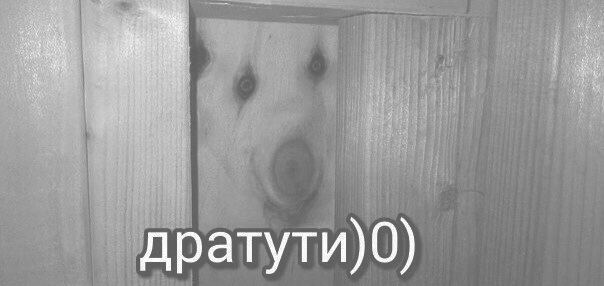

In [3]:
im.fromarray((Y * 255).astype('uint8'))

In [4]:
X_train = X.reshape((-1, X.shape[2]))
Y_train = Y.reshape(-1,)

Для начала посчитаем попарную корреляцию признаков и будем отбрасывать коррелирующие по некоторому трешхолду

<Axes: >

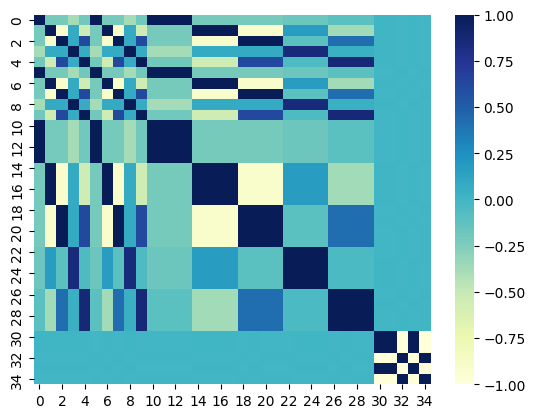

In [5]:
sns.heatmap(np.corrcoef(X_train.T), cmap="YlGnBu", annot=False)

Видим, что достаточно много коррелирующих

In [6]:
np.quantile(np.corrcoef(X_train.T)[0], 0.85)

0.9000000000000657

Будем использовать 0.85 как границу

In [7]:
threshold = 0.85
corr = np.corrcoef(X_train.T)
correlated = []
for i in range(corr.shape[0]):
    for j in range(i):
        if abs(corr[i, j]) >= threshold or abs(corr[i, j]) <= 1e-10:
            correlated.append(i)

In [8]:
X_dropped = np.delete(X_train, list(set(correlated)), axis=1)
X_dropped.shape

(172744, 4)

<Axes: >

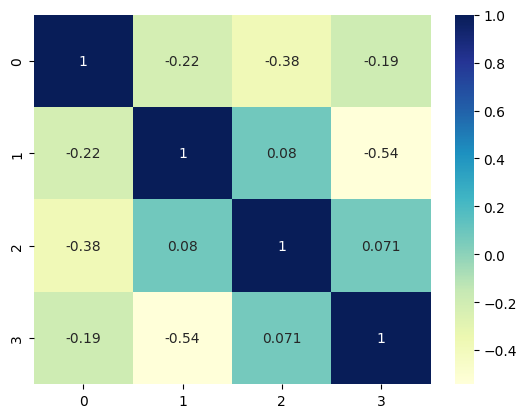

In [9]:
sns.heatmap(np.corrcoef(X_dropped.T), cmap="YlGnBu", annot=True)

Обучим катбуст из коробки, обычно это работает

In [10]:
import catboost as cb

In [103]:
model = cb.CatBoostRegressor(loss_function = "RMSE")
model.fit(X_dropped, Y_train)

Learning rate set to 0.092404
0:	learn: 0.1062016	total: 6.96ms	remaining: 6.95s
1:	learn: 0.0971087	total: 13.7ms	remaining: 6.83s
2:	learn: 0.0888748	total: 20.2ms	remaining: 6.72s
3:	learn: 0.0814756	total: 26ms	remaining: 6.48s
4:	learn: 0.0746943	total: 31.3ms	remaining: 6.23s
5:	learn: 0.0684505	total: 36.5ms	remaining: 6.04s
6:	learn: 0.0627944	total: 41.8ms	remaining: 5.92s
7:	learn: 0.0575225	total: 46.8ms	remaining: 5.81s
8:	learn: 0.0526466	total: 51.8ms	remaining: 5.7s
9:	learn: 0.0482327	total: 56.7ms	remaining: 5.61s
10:	learn: 0.0442057	total: 61.5ms	remaining: 5.53s
11:	learn: 0.0406763	total: 66.3ms	remaining: 5.46s
12:	learn: 0.0373957	total: 71ms	remaining: 5.39s
13:	learn: 0.0343617	total: 75.7ms	remaining: 5.33s
14:	learn: 0.0315798	total: 80.4ms	remaining: 5.28s
15:	learn: 0.0291056	total: 85.4ms	remaining: 5.25s
16:	learn: 0.0268249	total: 89.9ms	remaining: 5.2s
17:	learn: 0.0247598	total: 94.5ms	remaining: 5.15s
18:	learn: 0.0229169	total: 98.7ms	remaining: 5.09

In [104]:
print("Coefficient of determination: %.2f" % r2_score(Y_train, model.predict(X_dropped)))

Coefficient of determination: 1.00


Слишком большой, конечно, возможно переобучение и нужно поставить меньше итераций

Predict

In [115]:
X_test = np.load('./data/regression/regression_x_test.npy')
X_test_reshaped = X_test.reshape((-1, X_test.shape[2]))
X_test_dropped = np.delete(X_test_reshaped, list(set(correlated)), axis=1)
X_test_dropped.shape

(260400, 4)

In [116]:
Y_pred = model.predict(X_test_dropped)

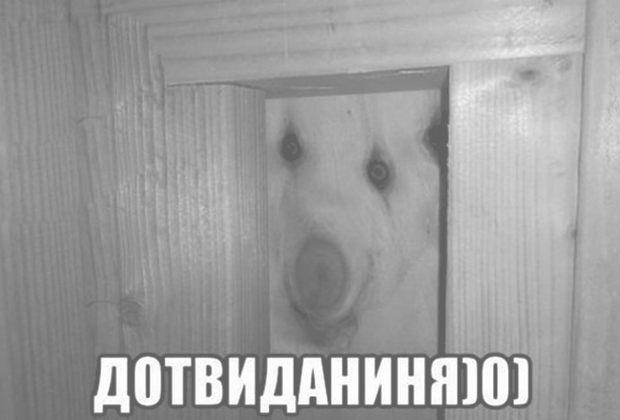

In [117]:
im.fromarray((Y_pred.reshape(X_test.shape[:2]) * 255).astype('uint8'))

Видно, что немного переобученный, но картинка в целом хорошая и смешная, так что всё ок и можно оставить так

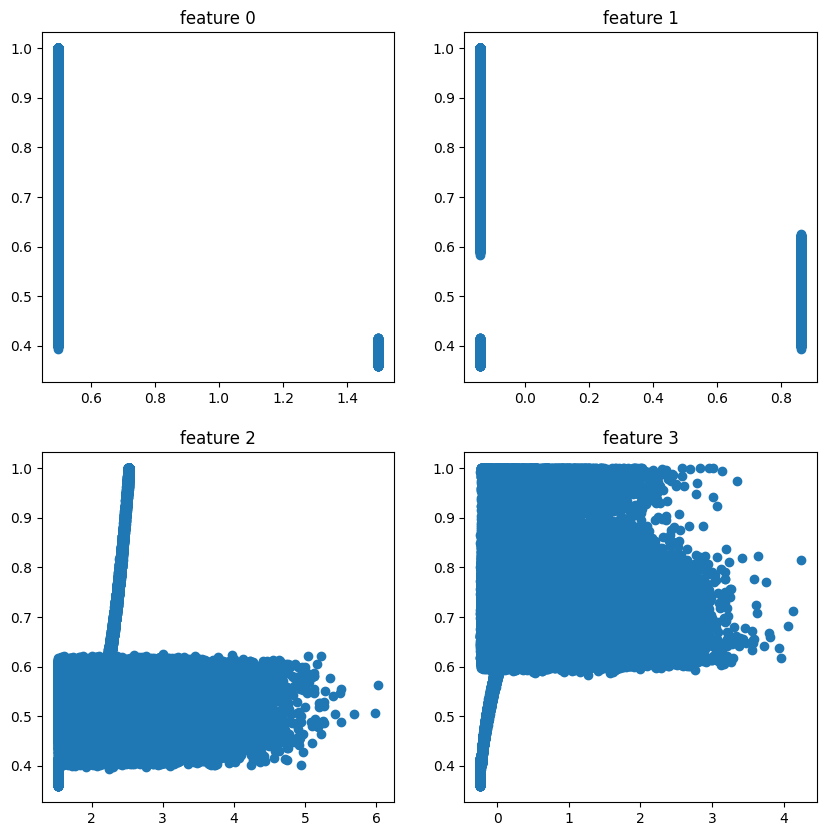

In [17]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
for i in range(2):
    for j in range(2):
        axs[i][j].scatter(X_dropped.T[2*i + j], Y_train)
        axs[i][j].set_title(f'feature {2*i + j}')

Тут видим, что фичи 0 1 являются категориальными, а 2 и 3 где-то коррелируют с тагретом